<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/chronoroot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChronoRoot　（未完）
訓練済みのモデルで根の解析を行うノートブック

## ライセンス
- ChronoRoot論文, Gaggion et al., 2021, GigaScience (https://academic.oup.com/gigascience/article/10/7/giab052/6324285)
    - CC-BY
- 公式レポジトリ (https://github.com/ngaggion/ChronoRoot)
    - GPLv3
- データセット (http://gigadb.org/dataset/100911)
    - GIGAdbの利用規約が定めるライセンス（http://gigadb.org/site/term; CC0相当）に準拠
- 本稿プログラムコード
    - **本章のコードは公式レポジトリのライセンスを継承してGPLv3となります。**

### メモ
python segmentFast.py imagePath --output_dir optionalSegPath --use_crf boolean --model ResUNetDS
- > 結果をchronorootで解析


## 環境構築

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# テストデータセットのダウンロード
!wget -O Test_ChronoRoot.zip https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100911/LabeledDataset/Test_ChronoRoot.zip
!unzip Test_ChronoRoot.zip
# !cp /content/drive/MyDrive/phenotyping_temp_assets/Test_ChronoRoot.zip ./
# !unzip Test_ChronoRoot.zip  > /dev/null 2>&1

In [ ]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/chronoroot/cr_resunetds.onnx ./

In [ ]:
# 公式レポジトリのクローニング
!git clone https://github.com/ngaggion/ChronoRoot.git

# 必要ライブラリのインストール
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git  > /dev/null 2>&1
!pip install onnx onnxruntime-gpu > /dev/null 2>&1

# 不要ファイルの削除
# !rm modelWeights.zip
# !rm Test_ChronoRoot.zip

Cloning into 'ChronoRoot'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 108 (delta 57), reused 88 (delta 39), pack-reused 0
Receiving objects: 100% (108/108), 925.53 KiB | 33.05 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
#https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=kDn_lVxg3Z2G
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update &>/dev/null
!apt-get install python3-graph-tool python3-matplotlib python3-cairo &>/dev/null
!apt purge python3-cairo &>/dev/null
!apt install libcairo2-dev pkg-config python3-dev &>/dev/null
!pip install --force-reinstall pycairo &>/dev/null
!pip install zstandard &>/dev/null
!apt-get install libzbar0 &>/dev/null
!pip install pyzbar &>/dev/null

Executing: /tmp/apt-key-gpghome.oT4N4YyeRo/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.8 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://downloads.skewed.de/apt jammy/main amd64 Packages [2,989 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-securit

5
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)


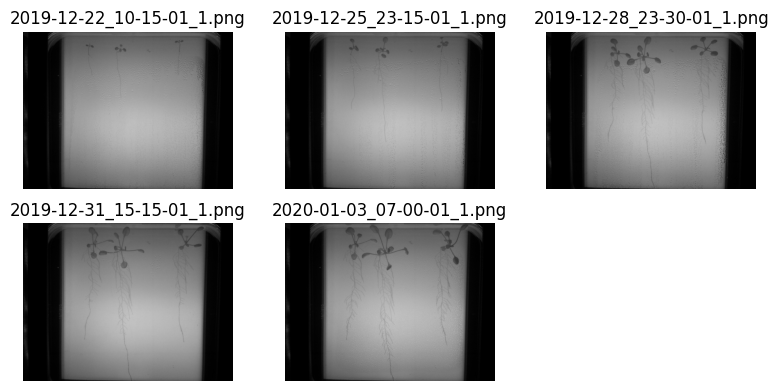

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = sorted([x for x in os.listdir(TEST_DIR) if x.endswith(".png")])
print(len(files))  # 5枚

plt.figure(figsize=(8,4))
for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path)
    print(image.shape)
    image = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    plt.subplot(2,3,i+1)
    plt.title(file)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()

In [ ]:
# 作者らの公式レポジトリのREADMEに従い、colaboratoryでsegmentFastやsegmentEnsembleを実行すると
# tensorflowのバージョン齟齬によりエラーがおきます。独自の環境で実行したい方は公式推奨のdockerイメージを利用してください。

In [ ]:
import onnxruntime as ort

In [ ]:
# classifier_path = "/content/ChronoRootEnsemble.onnx"
# providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
# ort_session = ort.InferenceSession(classifier_path, providers=providers)

# # inputとoutputの名前を把握します。
# input_names = [input.name for input in ort_session.get_inputs()]
# output_names = [output.name for output in ort_session.get_outputs()]

# print("Input names:", input_names)
# print("Output names:", output_names)

In [ ]:
import pydensecrf.densecrf as dcrf

def post_process(prediction):
    accum = np.zeros(prediction.shape[1:3])
    image = cv2.cvtColor((prediction[0,:,:,0]*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(prediction[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)

    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

def pad_image_to_multiple_of(v, multipleOf=[8, 8], mode='symmetric'):
    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])))
    return np.pad(v, padding, mode)

def preprocess(image):
    # assure dtype is float32
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    image = image[np.newaxis, ..., np.newaxis]
    return image


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gc
import onnxruntime as ort

In [ ]:
import time

In [ ]:
import tempfile

## ResUNetDSを用いた根のsegmentation

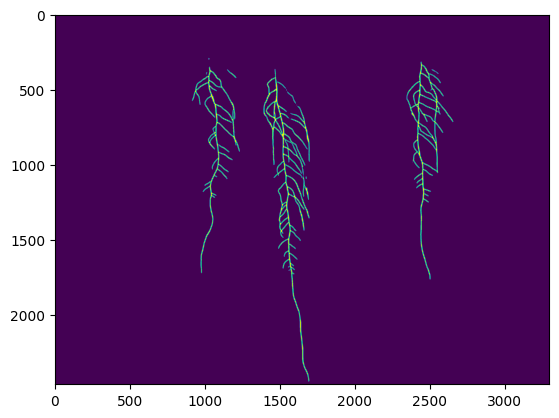

2019-12-31_15-15-01_1.png


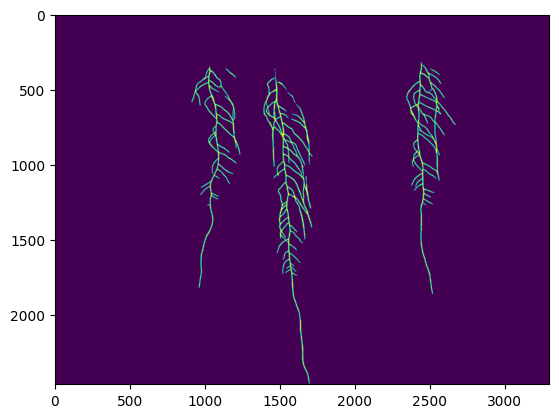

2020-01-03_07-00-01_1.png


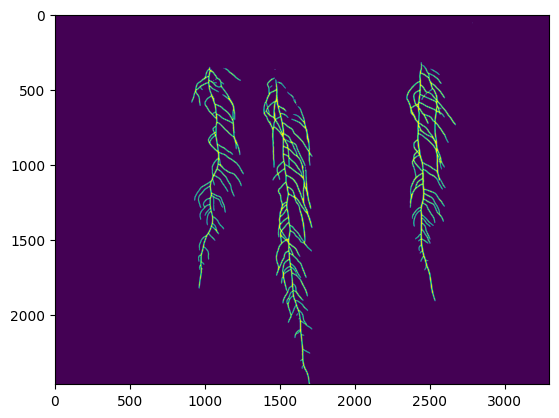

21701

In [ ]:
def single_crf(image, mask, accum):
    image *= 255.
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(mask[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)
    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

temp_dir = "/content/masks"
!mkdir {temp_dir}


model = "ResUNetDS"
classifier_path = os.path.join("/content/drive/MyDrive/phenotyping_temp_assets/chronoroot/",model+".onnx")
providers = ['CUDAExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

for i, file in enumerate(files):
    print(file)
    path = os.path.join(TEST_DIR, file)
    orig_image = cv2.imread(path, 0 )
    image = orig_image.copy()
    # image = preprocess(image)
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    # create accumulation template for crf
    if i == 0:
        accum = np.zeros_like(image)

    inputs = image[np.newaxis, ..., np.newaxis]
    predictions = ort_session.run(output_names, {input_names[0]: inputs})[0]
    accum = single_crf(image, predictions, accum)
    _, output = cv2.threshold(accum, 0.5, 1.0, cv2.THRESH_BINARY)
    # np.save(os.path.join(temp_dir, model+file+".npy"), output)
    plt.imshow(output)
    plt.show()
    cv2.imwrite(os.path.join(temp_dir,file), output*255)

# メモリ解放
del ort_session
gc.collect()

In [ ]:
# chronorootanalyzerの中のgetroiandseedの中のselectROIがcv2.selectroiでgui window依存。最初から切り抜いてここを迂回するスクリプトを組む必要あり。

import os
import csv
import cv2
import numpy as np
import json
from skimage.morphology import skeletonize

from ChronoRoot.graph.fileFunc import createResultFolder, loadPath  #, getROIandSeed
from ChronoRoot.graph.imageFunc import getCleanSeg, getCleanSke, savePlotImages, saveEmpty, plot_graph
from ChronoRoot.graph.graphFunc import createGraph, saveGraph, saveProps
from ChronoRoot.graph.trackFunc import graphInit, matchGraphs
from ChronoRoot.graph.rsmlFunc import createTree
from ChronoRoot.graph.graphPostProcess import trimGraph
from ChronoRoot.graph.dataWork import dataWork

[[876, 348, 1286, 1864], [1364, 434, 1824, 2464], [2312, 372, 2690, 1926]]


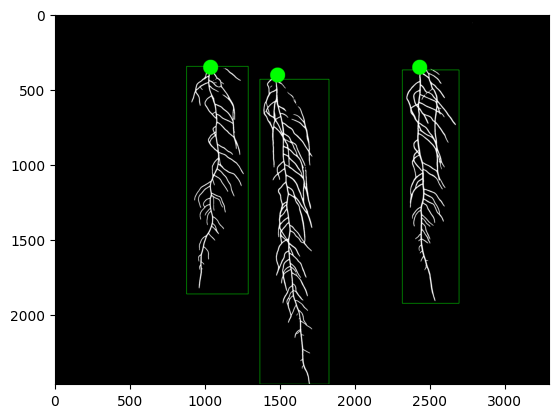

In [ ]:
mask_dir = "/content/masks"
# 日付が最も新しい写真を選ぶ
# newest_file = sorted(os.listdir(mask_dir))[-1]

image = cv2.imread("/content/masks/2020-01-03_07-00-01_1.png")

# 今回は手動でbboxを設定する
bboxes = [
    [876,348,876+410,348+1516],
    [1364,434,1364+460,434+2030],
    [2312,372,2312+378,372+1554]
]
seeds = [
    [1036,354],
    [1482,406],
    [2428,354]
]

print(bboxes)
for bbox in bboxes:
    image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,255,0), 2)
for seed in seeds:
    image = cv2.circle(image, (seed[0],seed[1]), 50, (0,255,0), -1)
plt.imshow(image)

In [ ]:
def assure_bbox_safe_coord(seed,bbox):
    # seedがbboxより外にあったときのことを考え、補正する
    seed[0] = np.max([bbox[0],seed[0]])
    seed[0] = np.min([bbox[2],seed[0]]) - bbox[0]
    seed[1] = np.max([bbox[1],seed[1]])
    seed[1] = np.min([bbox[3],seed[1]]) - bbox[1]
    seed = [x.astype(np.uint16) for x in seed]
    return seed

def get_crop_from_segmentation(mask, bbox, seed):
    # https://github.com/ngaggion/ChronoRoot/blob/master/graph/imageFunc.pyより改変
    # seedより上を黒く塗りつぶす
    # mask[0:seed[1], :] = 0
    # bboxに基づいてクロップする
    seg = mask[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    seg[0: seed[1],:] = 0
    return seg

def clean_segmentation(seg):
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_size,kernel_size))
    seg = cv2.dilate(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.erode(seg, kernel)
    seg = cv2.dilate(seg, kernel)
    return seg

def filter_segmentation(seg, seed):
    contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    if len(contour_sizes) != 0:
        ### Sorts list of contours by size from bigger to smaller
        contour_sizes.sort(key=lambda x: x[0], reverse=True)
        for contour in contour_sizes:
            if contour[0] < 30:
                break
            else:
                dist = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), True)
                dist = np.abs(dist)
                is_in = cv2.pointPolygonTest(contour[1],(seed[0], seed[1]), False) > 0

                if (dist < 30 or is_in):
                    mask = np.zeros(seg.shape, np.uint8)
                    cv2.drawContours(mask,[contour[1]], -1, 255, -1)
                    seg2 = cv2.bitwise_and(mask, seg.copy())

                    return seg2, True

    return seg, False

def graph_reconstruction(image_dir, mask_dir, bboxes, seeds):
    # bboxesとseedsのlength, 対応オブジェクトの順番は揃えること

    image_files = [file for file in sorted(os.listdir(image_dir)) if file.endswith("png")]
    mask_files = [file for file in sorted(os.listdir(mask_dir)) if file.endswith("png")]

    results = {}
    for i,(bbox,seed) in enumerate(zip(bboxes, seeds)):
        print("bbox:", i)
        results[i] = {}

        original_seed = assure_bbox_safe_coord(seed,bbox)

        for t, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
            results[i][t] = {}
            print("\t",image_file)
            image = cv2.imread(os.path.join(image_dir, image_file))
            mask = cv2.imread(os.path.join(mask_dir, mask_file), 0)
            seg = get_crop_from_segmentation(mask, bbox, original_seed)
            seg = clean_segmentation(seg)
            seg, seg_presence = filter_segmentation(seg, original_seed)

            results[i][t]["raw"] = image[bbox[1]:bbox[3],bbox[0]:bbox[2],:]
            results[i][t]["seg"] = seg

            if seg_presence:
                results[i][t]["valid"] = True
                ske, bnodes, enodes, flag = getCleanSke(seg)
                grafo, seed, ske2 = createGraph(ske.copy(), original_seed, enodes, bnodes)
                grafo, ske, ske2 = trimGraph(grafo, ske, ske2)
                grafo = graphInit(grafo)
                #saveGraph(grafo, gPath)
                #print(grafo)
                # confがないため再実装する?
                conf = {}
                conf["Path"] = "dummy"
                conf["filekey"] = "Long day condition" # Identifier for the RSML file
                conf["sequenceLabel"] = "rpi6" # Identifier for the sequence
                conf["Plant"] = "Arabidopsis thaliana" # Plant under study
                rsmlTree, numberLR = createTree(conf, i, images, grafo, ske, ske2)

                # フォルダが自動生成されないっぽい
                # savePlotImages(str(i).zfill(2)+image_file,
                #                "./",
                #                image[bbox[1]:bbox[3],bbox[0]:bbox[2],:],
                #                seg, grafo, ske2)


                grafo_img = plot_graph(grafo, results[i][t]["raw"].shape)
                results[i][t]["graph"] = grafo_img
            else:
                results[i][t]["valid"] = False
            print("\t\t",results[i][t]["valid"])
    return results

image_dir = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
mask_dir = "/content/masks"

bboxes = [
    [876,348,876+410,348+1516],
    [1364,434,1364+460,434+2030],
    [2312,372,2312+378,372+1554]
]
seeds = [
    [1036,354],
    [1482,406],
    [2428,354]
]

results = graph_reconstruction(image_dir, mask_dir, bboxes, seeds)

bbox: 0
	 2019-12-22_10-15-01_1.png
		 True
	 2019-12-25_23-15-01_1.png
		 True
	 2019-12-28_23-30-01_1.png
		 True
	 2019-12-31_15-15-01_1.png
		 True
	 2020-01-03_07-00-01_1.png
		 True
bbox: 1
	 2019-12-22_10-15-01_1.png
		 True
	 2019-12-25_23-15-01_1.png
		 True
	 2019-12-28_23-30-01_1.png
		 True
	 2019-12-31_15-15-01_1.png
		 True
	 2020-01-03_07-00-01_1.png
		 True
bbox: 2
	 2019-12-22_10-15-01_1.png
		 True
	 2019-12-25_23-15-01_1.png
		 True
	 2019-12-28_23-30-01_1.png
		 True
	 2019-12-31_15-15-01_1.png
		 True
	 2020-01-03_07-00-01_1.png
		 True


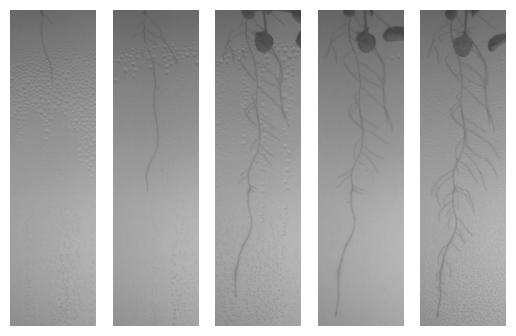

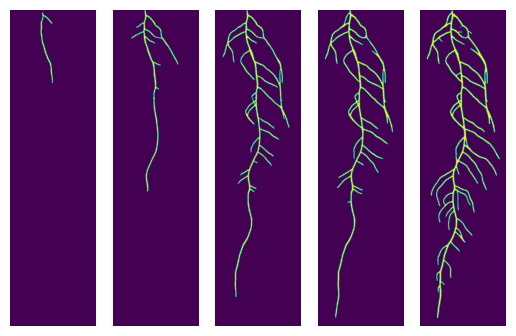

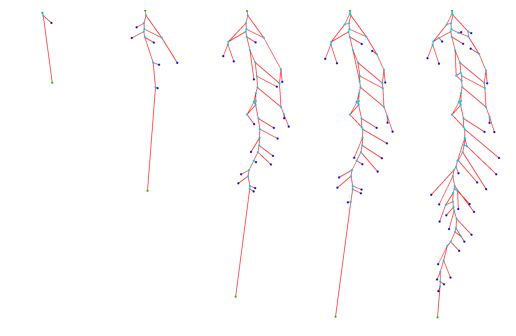

In [ ]:
# bboxの文だけiterate。
# draw raw
for i in range(len(results)):
    for t in range(len(results[i])):
        plt.subplot(1,len(results[i]), t+1)
        plt.imshow(results[i][t]["raw"])
        plt.axis("off")
    plt.show()
    for t in range(len(results[i])):
        plt.subplot(1,len(results[i]), t+1)
        plt.imshow(results[i][t]["seg"])
        plt.axis("off")
    plt.show()
    for t in range(len(results[i])):
        if results[i][t]["valid"]:
            plt.subplot(1,len(results[i]), t+1)
            plt.imshow(results[i][t]["graph"])
            plt.axis("off")
    plt.show()
    break

## 最後に
ChronoRootの公式実装では、抽出されたグラフに対し、時系列間で比較し整合性を取る処理を行っています。
興味ある方は https://github.com/ngaggion/ChronoRoot/blob/master/graph/ChronoRoot.py を参照してください。